#### Importing neccessary libraries

1. **Numpy** for *linear algebra*
2. **Pandas** for reading csv files and DataFrame handling
3. **Tensorflow** for *machine learning*
4. **Keras** for defining the *LSTM model architecture* and regularization
5. Functions such as **train_test_split** for dividing the dataset into training and test set and **GridSearchCV** to tune hyperparameters across a grid of values.
6. **MinMaxScaler** to scale the variable values to a range of $[0,1]$.  
7. **matplotlib** for plotting results
8. **logging** for errors.

In [1]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 40.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [175]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasClassifier
from itertools import product
import matplotlib.pyplot as plt
import logging
from keras.regularizers import l2

# 6 iterations:
1. -> 1 lstm layers gridsearch  
2. -> 2 lstm layer gridsearch  
3. -> 1 lstm layer med l1 eller l2 gridsearch  
4. -> 1 lstm layer for kun makro gridsearch  
5. -> 1 lstm layer for kun technical gridsearch  
6. -> 1 lstm layer med inflation og unemployment + tekniske (Momentum, RSI, MACD, MA) gridsearch


## Configuration of logging:

In [176]:
logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')

## Setting Device to GPU

Since the model is run in Google Colab with an external GPU for increased computational ability the device which is used needs to be defined:

In [208]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    logging.warning('GPU device not found. Use CPU instead')
else:
    logging.info(f'Found GPU at: {device_name}')

# Data Loading

In [209]:
logging.info('Loading dataset...')

file_path = '/content/final_dataset.csv'
df = pd.read_csv(file_path)
dataset = df.values[:, 1:].astype('float64') # Later this can be changed to float64 for further precision.

diff = dataset[:,:1]

In [210]:
np.random.seed(42)
tf.random.set_seed(42)

# Output Variable Transformation and Data Scaling

In [71]:
# Define a function to categorize the percent change
# Values for (25,75) and (40,60) percentiles are listed below. Both will be tested.
#25th: -0.0037000000000000366
#75th: 0.003649999999999931
#40th: -0.0012000000000000899
#60th: 0.0013000000000000789
#33th: -0.0023999999999999
#66th: 0.0021999999999999

def categorize_diff(diff):
    if diff < -0.0021999999999999:
        return 0  # Price falls
    elif diff > 0.002:
        return 2  # Price rises
    else:
        return 1  # Price stays the same

# Apply the function to y_diff to get the categories
logging.info('Categorizing percent change...')
y_categories = np.array([categorize_diff(pc) for pc in diff])

# Normalizing dataset
logging.info('Normalizing dataset...')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset[:, 1:])


# Conversion to Tensor

In [211]:
def create_dataset(dataset, time_steps=1):
    dataX = []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), :]
        dataX.append(a)
    return np.array(dataX)

# 1st Model

* time steps = 10,
* epochs = 100,
* 1 hidden layer,
* 0.3 dropout rate,
* 32 batch size,

In [ ]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [ ]:
def create_model(units1=128, dropout_rate1 = 0.3, batch_size = 32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(model=create_model, epochs = 75, verbose=0, shuffle = False, random_state = 42)

In [ ]:
param_grid = {
    'model__units1': [32, 64, 128, 256],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'batch_size': [32, 64, 128]
}

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs = -1)

In [ ]:
# Fit the grid search
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
best_params = grid_result.best_params_
logging.info(f"Best Parameters: {best_params}")
print(best_params)

{'batch_size': 32, 'model__dropout_rate1': 0.4, 'model__units1': 128}


In [ ]:
best_model = create_model(batch_size = best_params['batch_size'],
                          dropout_rate1 = best_params['model__dropout_rate1'],
                          units1 = best_params['model__units1']
                          )

In [ ]:
history = best_model.fit(X_train, y_train,
                         epochs = 75,
                         batch_size = best_params['batch_size'],
                         validation_data = (X_test, y_test),
                         shuffle = False,
                         verbose=0
                         )

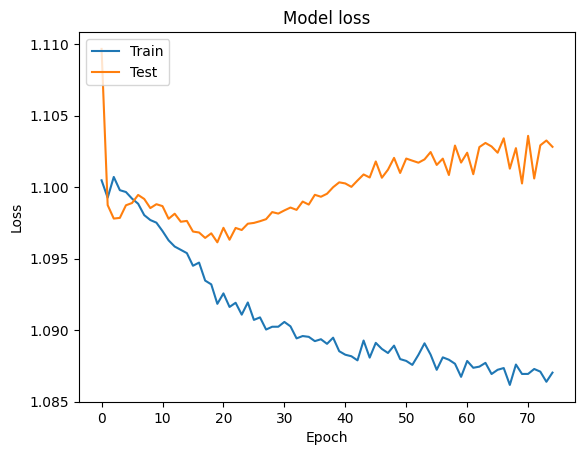

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<Figure size 1000x700 with 0 Axes>

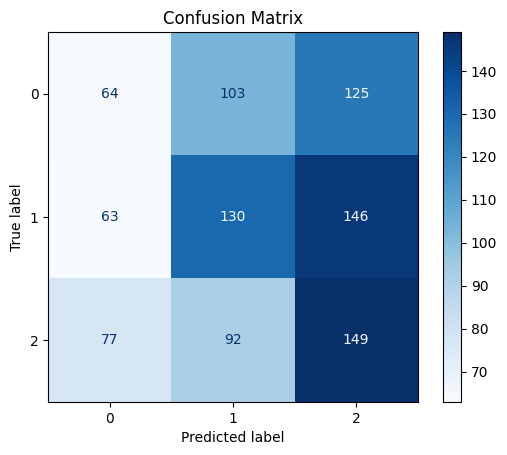

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model.predict(X_test)

actual_categories = y_test
predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,779 (940.55 KB)

 Trainable params: 80,259 (313.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,520 (627.04 KB)

In [ ]:
model_save_path = 'first_iteration_lstm.keras'
best_model.save(model_save_path)
logging.info(f"Model saved to {model_save_path}")


In [ ]:
loaded_model = tf.keras.models.load_model(model_save_path)
loaded_model.summary()

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                       │ (None, 128)                 │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,779 (940.55 KB)

 Trainable params: 80,259 (313.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,520 (627.04 KB)

# 2nd Iteration

2 lstm layer gridsearch

In [ ]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [ ]:
def create_model_2(units1=128, units2 = 64, dropout_rate1 = 0.3, dropout_rate2 = 0.2, batch_size = 32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = True),
        Dropout(dropout_rate1),
        LSTM(units2, return_sequences = False),
        Dropout(dropout_rate2),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_2 = KerasClassifier(model=create_model_2, epochs = 75, verbose=0, shuffle = False, random_state = 42)

In [ ]:
param_grid_model2 = {
    'model__units1': [32, 64, 128],
    'model__units2': [32, 64, 128],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'model__dropout_rate2': [0.3, 0.2, 0.1],
    'batch_size': [32, 64, 128]
}

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_2 = GridSearchCV(estimator=model_2, param_grid=param_grid_model2, cv=5, n_jobs = -1)

In [ ]:
# Fit the grid search
grid_result_model_2 = grid_model_2.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
best_params_model_2 = grid_result_model_2.best_params_
logging.info(f"Best Parameters: {best_params_model_2}")
print(best_params_model_2)

{'batch_size': 32, 'model__dropout_rate1': 0.2, 'model__dropout_rate2': 0.1, 'model__units1': 128, 'model__units2': 128}


In [ ]:
best_model_2 = create_model_2(units1=best_params_model_2['model__units1'],
                            units2 = best_params_model_2['model__units2'],
                          dropout_rate1 = best_params_model_2['model__dropout_rate1'],
                            dropout_rate2 = best_params_model_2['model__dropout_rate2'],
                          batch_size = best_params_model_2['batch_size']
                          )

In [ ]:
history_model_2 = best_model_2.fit(X_train, y_train,
                         epochs=75,
                         validation_data=(X_test, y_test),
                         verbose=0)

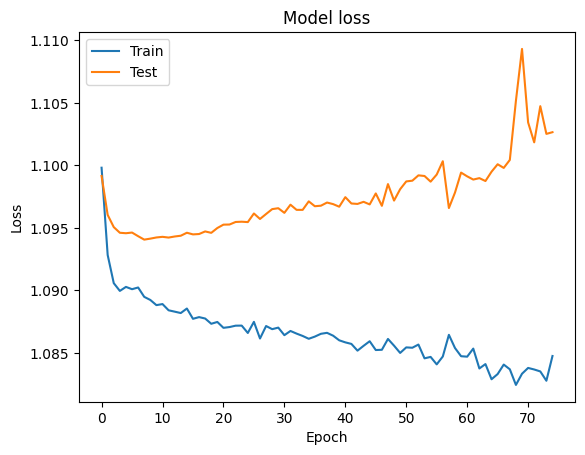

In [ ]:
# Plot training & validation loss values
plt.plot(history_model_2.history['loss'])
plt.plot(history_model_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<Figure size 1000x700 with 0 Axes>

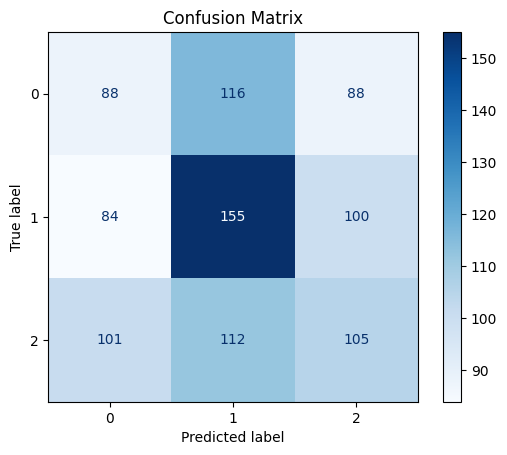

In [ ]:
y_pred = best_model_2.predict(X_test)

actual_categories = y_test
predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
best_model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 15, 128)             │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 635,531 (2.42 MB)

 Trainable params: 211,843 (827.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 423,688 (1.62 MB)

In [ ]:
model_2_save_path = 'second_iteration_lstm.keras'
best_model_2.save(model_2_save_path)
logging.info(f"Model saved to {model_2_save_path}")


# 3rd Iteration

1 lstm layer med l1 eller l2 gridsearch  


In [ ]:
from tensorflow.keras.regularizers import l1_l2

In [ ]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
def create_model_3(units1=128, dropout_rate1 = 0.3, batch_size = 32, l1 = 0.01, l2 = 0.01):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax', kernel_regularizer = l1_l2(l1=l1, l2=l2))
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_3 = KerasClassifier(model=create_model_3, epochs = 100, verbose=0, random_state = 42)

In [ ]:
param_grid_model3 = {
    'model__units1': [32, 64, 128],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'batch_size': [32, 64, 128],
    'model__l1': [0.01, 0.001],
    'model__l2': [0.01, 0.001]
}

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_3 = GridSearchCV(estimator=model_3, param_grid=param_grid_model3, cv=5, n_jobs = -1)

In [ ]:
# Fit the grid search
grid_result_model_3 = grid_model_3.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
best_params_model_3 = grid_result_model_3.best_params_
logging.info(f"Best Parameters: {best_params_model_3}")
print(best_params_model_3)

{'batch_size': 32, 'model__dropout_rate1': 0.4, 'model__l1': 0.01, 'model__l2': 0.01, 'model__units1': 128}


In [ ]:
best_model_3 = create_model_3(units1 = best_params_model_3['model__units1'],
                          dropout_rate1 = best_params_model_3['model__dropout_rate1'],
                          batch_size = best_params_model_3['batch_size'],
                          l1 = best_params_model_3['model__l1'],
                          l2 = best_params_model_3['model__l2']
                          )

In [ ]:
history_model_3 = best_model_3.fit(X_train, y_train,
                         epochs=100,
                         validation_data=(X_test, y_test),
                         verbose=0)

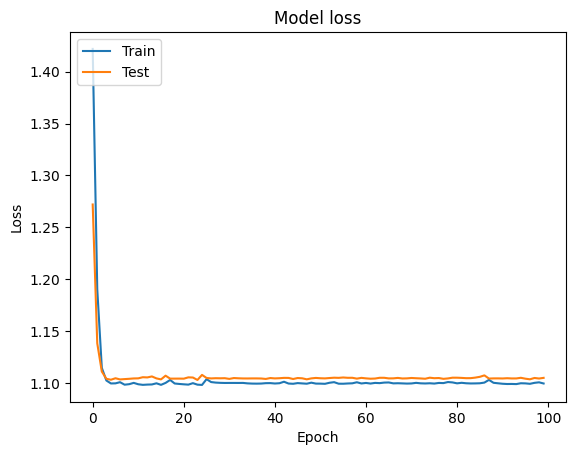

In [ ]:
# Plot training & validation loss values
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<Figure size 1000x700 with 0 Axes>

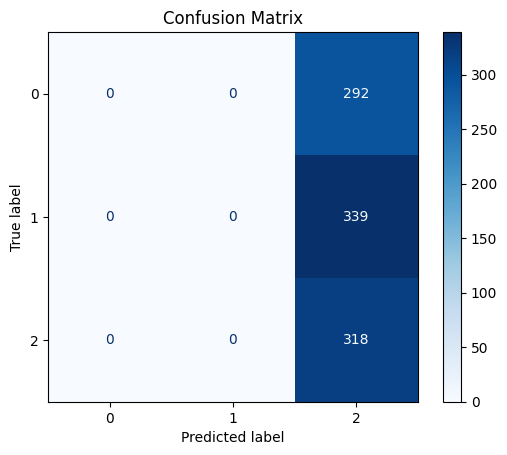

In [ ]:
y_pred = best_model_3.predict(X_test)

actual_categories = y_test
predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
best_model_3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 128)                 │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,779 (940.55 KB)

 Trainable params: 80,259 (313.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,520 (627.04 KB)

In [ ]:
model_3_save_path = 'third_iteration_lstm.keras'
best_model_3.save(model_3_save_path)
logging.info(f"Model saved to {model_3_save_path}")


# 4th Iteration

SLSTM with only technical variables


In [69]:
logging.info('Loading dataset...')

file_path = '/content/technical_indicators_stationary.csv'
df = pd.read_csv(file_path)
df = df.drop(columns = ['date'])
dataset = df.values[:, 0:].astype('float64') # Later this can be changed to float64 for further precision.

diff = dataset[:,1:2]

In [49]:
print(diff)

[[-0.0003]
 [-0.0105]
 [-0.0125]
 ...
 [ 0.0079]
 [-0.0041]
 [-0.0011]]


In [73]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [74]:
def create_model_4(units1 = 128, dropout_rate1 = 0.2, batch_size = 32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation = 'softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [75]:
param_grid_model_4 = {
    'model__units1': [32, 64, 128],
    'model__dropout_rate1': [0.1, 0.2, 0.3],
    'batch_size': [32, 64, 128]
}

In [76]:
model_4 = KerasClassifier(model=create_model_4, epochs = 75, verbose=0, random_state = 42)

In [77]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_4 = GridSearchCV(estimator=model_4, param_grid=param_grid_model_4, cv=5, scoring = 'accuracy', n_jobs = -1)

In [78]:
# Fit the grid search
grid_result_model_4 = grid_model_4.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [58]:
best_params_model_4 = grid_result_model_4.best_params_
logging.info(f"Best Parameters: {best_params_model_4}")
print(best_params_model_4)

{'batch_size': 64, 'model__dropout_rate1': 0.3, 'model__units1': 32}


In [59]:
best_model_4 = create_model_4(units1 = best_params_model_4['model__units1'],
                          dropout_rate1 = best_params_model_4['model__dropout_rate1'],
                          batch_size = best_params_model_4['batch_size']
                          )

In [66]:
history_model_4 = best_model_4.fit(X_train, y_train,
                         epochs=30,
                         validation_data=(X_test, y_test),
                         verbose=0)

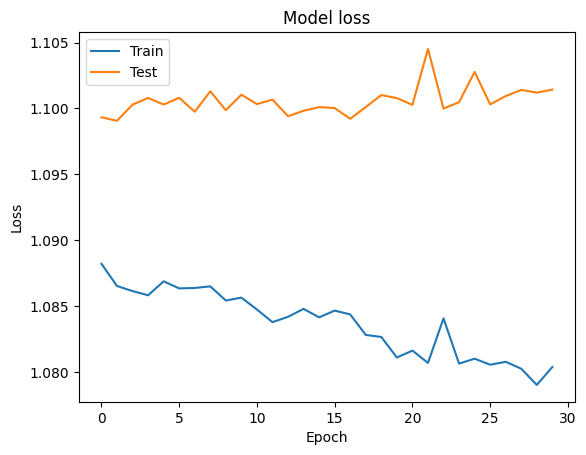

In [67]:
# Plot training & validation loss values
plt.plot(history_model_4.history['loss'])
plt.plot(history_model_4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<Figure size 1000x700 with 0 Axes>

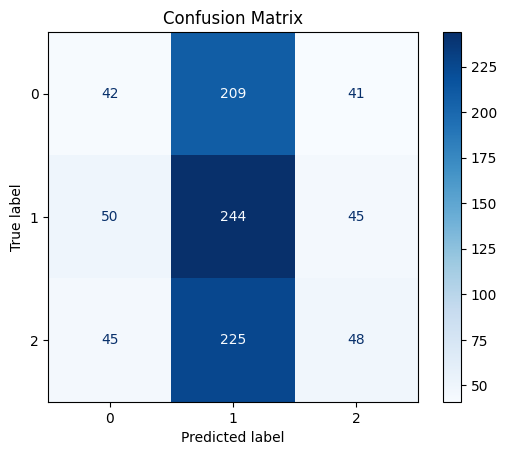

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model_4.predict(X_test)

actual_categories = y_test
predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [64]:
best_model_4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 32)                  │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,195 (67.17 KB)

 Trainable params: 5,731 (22.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,464 (44.79 KB)

In [65]:
model_4_save_path = 'fourth_iteration_lstm.keras'
best_model_4.save(model_4_save_path)
logging.info(f"Model saved to {model_4_save_path}")

# 5th Model (Not run yet)

In [149]:
def categorize_diff(diff):
    if diff <= -0.0060:
        return 0  # Strong Sell
    elif -0.0060 < diff <= -0.0023:
        return 1  # Weak Sell
    elif -0.0023 < diff <= 0.0023:
        return 2  # No Action
    elif 0.0023 < diff <= 0.0056:
        return 3  # Weak Buy
    else:
        return 4  # Strong Buy

In [213]:
# Apply the function to y_diff to get the categories
#logging.info('Categorizing percent change...')
#y_categories = np.array([categorize_diff(pc) for pc in diff])

# Normalizing dataset
logging.info('Normalizing dataset...')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset[:, 1:])

In [214]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = diff[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [255]:
from tensorflow.keras.losses import Huber


def create_model_5(units1=128, dropout_rate1=0.3, batch_size=32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences=False),
        Dropout(dropout_rate1),
        Dense(units1, activation='relu'),
        Dense(1)  # Single unit for regression output
    ])

    model.compile(optimizer='adam', loss = Huber(), metrics=['mae'])
    return model

In [256]:
from scikeras.wrappers import KerasRegressor

model_5 = KerasRegressor(build_fn=create_model_5, epochs = 75, verbose=0, random_state = 42)

In [257]:
param_grid_model_5 = {
    'model__units1': [32, 64, 128, 256],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'batch_size': [32, 64, 128]
}

In [258]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_5 = GridSearchCV(estimator=model_5, param_grid=param_grid_model_5, cv=5, n_jobs = -1)

In [ ]:
# Fit the grid search
grid_result_model_5 = grid_model_5.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [241]:
best_params_model_5 = grid_result_model_5.best_params_
logging.info(f"Best Parameters: {best_params_model_5}")
print(best_params_model_5)

{'batch_size': 64, 'model__dropout_rate1': 0.4, 'model__units1': 32}


In [250]:
best_model_5 = create_model_5(batch_size = best_params_model_5['batch_size'],
                          dropout_rate1 = best_params_model_5['model__dropout_rate1'],
                          units1 = best_params_model_5['model__units1'],
                          )

In [251]:
history_model_5 = best_model_5.fit(X_train, y_train,
                         epochs = 20,
                         validation_data = (X_test, y_test),
                         verbose=1,
                          shuffle = False
                         )

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0037 - mae: 0.0586 - val_loss: 6.1446e-05 - val_mae: 0.0091
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9832e-04 - mae: 0.0188 - val_loss: 5.1404e-05 - val_mae: 0.0084
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4777e-04 - mae: 0.0130 - val_loss: 3.0907e-05 - val_mae: 0.0063
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0464e-04 - mae: 0.0108 - val_loss: 3.0453e-05 - val_mae: 0.0063
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.5081e-05 - mae: 0.0097 - val_loss: 3.2467e-05 - val_mae: 0.0065
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3262e-05 - mae: 0.0085 - val_loss: 2.2656e-05 - val_mae: 0.0053
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7995e-05 - mae: 0.0080 - val_loss: 1.9764e-05 - val_mae: 0.0049
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1739e-05 - mae: 0.0076 - val_loss: 1.9998e-05 - val_mae: 0.0

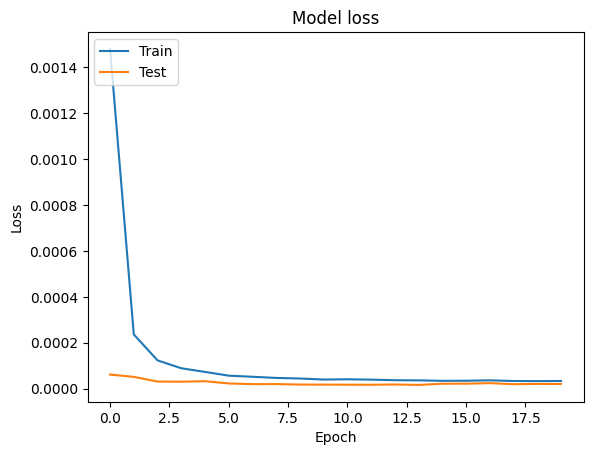

In [252]:
# Plot training & validation loss values
plt.plot(history_model_5.history['loss'])
plt.plot(history_model_5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


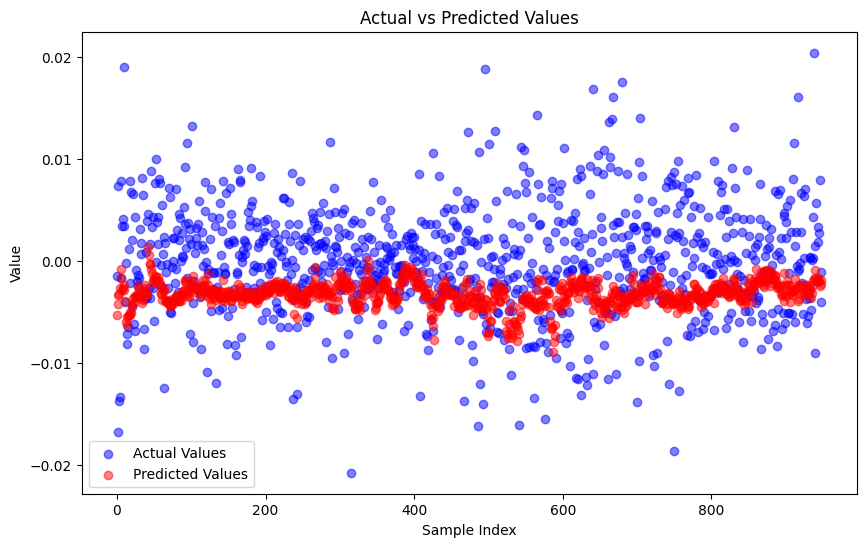

In [253]:
import matplotlib.pyplot as plt

# Assuming best_model_5 is your trained model and X_test, y_test are your test data

# Obtain predictions
y_pred = best_model_5.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual Values', color='b', alpha = 0.5)
plt.scatter(range(len(y_test)), y_pred, label='Predicted Values', color='r', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error (MSE): 4.062487784338523e-05
Mean Absolute Error (MAE): 0.005018397195761051
R^2 Score: -0.40716911851125337
Out-of-Sample (OOS) R^2 Score: -0.40716911851125337


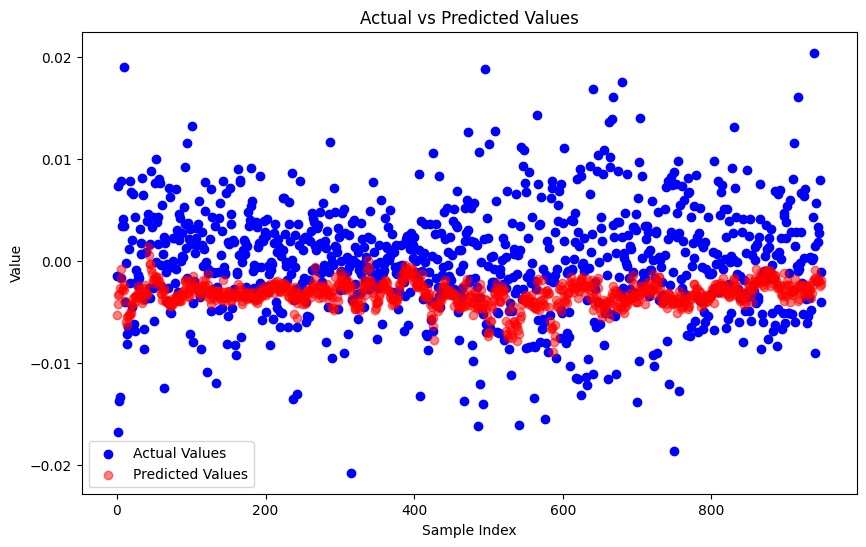

In [254]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = best_model_5.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

# Calculate Out-of-Sample (OOS) R^2
def oos_r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

oos_r2 = oos_r2_score(y_test, y_pred)
print(f'Out-of-Sample (OOS) R^2 Score: {oos_r2}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual Values', color='b')
plt.scatter(range(len(y_test)), y_pred, label='Predicted Values', color='r', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, color='purple', alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=len(residuals), linestyles='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Residual')
plt.title('Residuals Plot')
plt.show()

# Calculate additional metrics
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'Median Absolute Error (MedAE): {medae}')


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


<Figure size 1000x700 with 0 Axes>

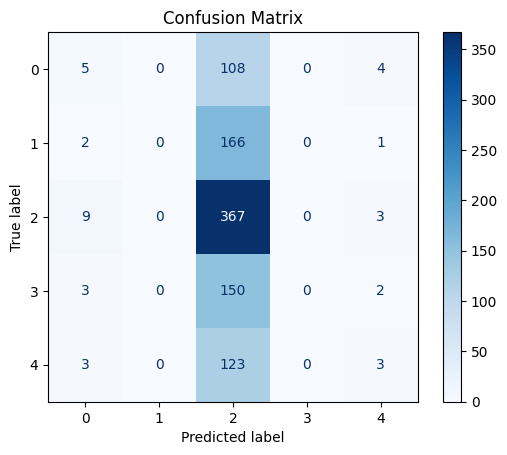

In [174]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = best_model_5.predict(X_test)

# Since best_model_5 is likely a Keras model wrapped in a Scikit-learn classifier,
# we need to convert predictions from probability distributions to class labels.
predicted_categories = np.argmax(y_pred, axis=1)

# Ensure that actual_categories has the correct length
actual_categories = y_test

# Compute the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
best_model_5.summary()

In [ ]:
model_save_path = 'fifth_iteration_lstm.keras'
best_model_5.save(model_save_path)
logging.info(f"Model saved to {model_save_path}")
